# Time series classification with sktime

The time series classification (TSC) task involves training a model from a collection
 of time series (real valued, ordered, data) in order to predict a target variable.
 For example, we might want to build a model that can predict whether a patient is
 sick based on the ECG reading, or predict whether a device will fail based on some
 sensor reading. This notebook gives a quick guide to get you started

## Data sets and problem types

The UCR/UEA [time series classification archive](https://timeseriesclassification.com/)
contains a large number of example TSC problems that have been used thousands of times
in the literature to assess TSC algorithms. These dataset have certain
characteristics, that influence what data structure we use to store them in memory.

Most datasets contain time series all of the same length. For example, the [arrow
head dataset](https://timeseriesclassification.com/description.php?Dataset=ArrowHead) consists of outlines of the images of arrow heads. The
classification of projectile points is an important topic in anthropology.
<img src="./img/arrow-heads.png" width="400" alt="arrow heads">

The shapes of the projectile points are converted into a sequence using the
angle-based method as described in this [blog post](https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html) about converting images into time series for data mining.

<img src="./img/from-shapes-to-time-series.png" width="400" alt="from shapes to time series">

Each instance consists of a single time series (i.e. the problem is univariate) of
equal length and a class label based on shape distinctions such as the presence and
location of a notch in the arrow. The data set consists of 21 instances, by
default split into 36 train and 175 test instances. We refer to the collection of
time series as $X$ and to the collection of class labels as $y$. This type of dataset
 is most naturally stored in a two dimensional numpy array for $X$ and one
 dimensional numpy array for $y$.

(36, 251) (36,) (175, 251) (175,)


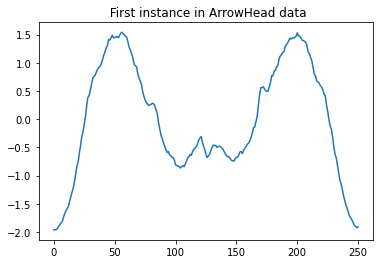

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sktime.datasets import load_arrow_head

# Random train set for a two class problem with 10 instances of length 50
random_train_X = np.random.rand(10, 50)
random_train_y = np.random.randint(low=0, high=2, size=10)

# Load all arrow head
arrow_X, arrow_y = load_arrow_head()
# Load default train/test splits from sktime/datasets/data
arrow_train_X, arrow_train_y = load_arrow_head(split="train")
arrow_test_X, arrow_test_y = load_arrow_head(split="test")
print(arrow_train_X.shape, arrow_train_y.shape, arrow_test_X.shape, arrow_test_y.shape)
plt.title(" First instance in ArrowHead data")
plt.plot(arrow_train_X[0])

Some TSC datasets are multivariate, in that each instance has more than one
associated time series. For example, the problem [basic motions dataset](https://timeseriesclassification.com/description.php?Dataset=BasicMotions)
The data was generated as part of a student project where four students performed
four activities whilst wearing a smart watch. The watch collects 3D accelerometer and
 a 3D gyroscope. Each instance involved a subject performing one of four tasks (walking,
 resting, running and badminton) for ten seconds. The data has 6 dimensions.

<class 'numpy.ndarray'>
(40, 6, 100) (40,) (40, 6, 100) (40,)


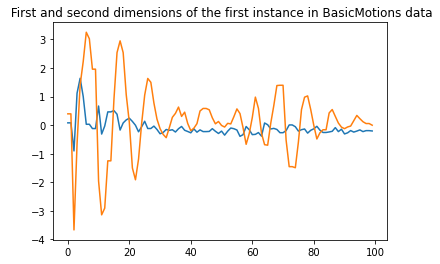

In [2]:
# Random train set for a multivariate two class problem with 10 instances of length 50
random_train_X = np.random.rand(10, 6, 50)
random_train_y = np.random.randint(low=0, high=2, size=10)

from sktime.datasets import load_basic_motions

# Load all arrow head
# arrow_X, arrow_y = load_arrow_head()
# Load default train/test splits from sktime/datasets/data
motions_X, motions_Y = load_basic_motions()
motions_train_X, motions_train_y = load_basic_motions(split="train")
motions_test_X, motions_test_y = load_basic_motions(split="test")
print(type(motions_train_X))
print(
    motions_train_X.shape,
    motions_train_y.shape,
    motions_test_X.shape,
    motions_test_y.shape,
)
plt.title(" First and second dimensions of the first instance in BasicMotions data")
plt.plot(motions_train_X[0][0])
plt.plot(motions_train_X[0][1])

Some data sets have unequal length series. Two data sets with this characteristic
are shipped with sktime: PLAID (univariate) and JapaneseVowels (multivariate). We
cannot store unequal length series in numpy arrays. Instead, we use nested pandas
data frames,
where each cell is a pandas Series.

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

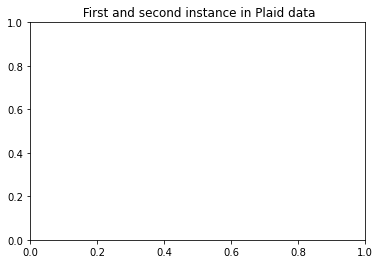

In [3]:
from sktime.datasets import load_japanese_vowels

vowel_X, vowel_y = load_japanese_vowels()
plt.title(" First and second instance in Plaid data")
plt.plot(vowel_X.iloc(0, 0))
plt.show()

## Building Classifiers

It is possible to use a standard sklearn classifier for univariate classification
problems but it is unlikely to perform as well as bespoke time series classifiers.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(arrow_train_X, arrow_train_y)
y_pred = classifier.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

You cannot use sklearn classifiers directly with multivariate or unequal length data
sets. sktime contains the state of the art in time series classifiers in the package
classification. These are grouped based on their representation. An accurate and
relatively fast classifier is called [ROCKET](https://arxiv.org/abs/1910.13051)

In [ ]:
from sktime.classification.kernel_based import RocketClassifier

rocket = RocketClassifier()
rocket.fit(arrow_train_X, arrow_train_y)
y_pred = rocket.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

The current state of the art for TSC is version 2 of the [HIVE-COTE algorithm]
(https://link.springer.com/article/10.1007/s10994-021-06057-9). HC2 is slow on small
problems like these examples. However, it can be configured with an approximate
maximum run time as follows.

In [ ]:
from sktime.classification.hybrid import HIVECOTEV2

hc2 = HIVECOTEV2(time_limit_in_minutes=2)
hc2.fit(arrow_train_X, arrow_train_y)
y_pred = hc2.predict(arrow_test_X)
accuracy_score(arrow_test_y, y_pred)

Some classifiers are configured to work with multivariate input.

In [ ]:
rocket.fit()